In [42]:
from orbit import Orbit, AU2km, mu, day2s, ISP, g0
import elements as el
import angles as an
from util import select_asteroid
from util import asteroids, earth, asteroid_ind

from node import Node

import lambert_combine as lb
#from lambert_izzo import lambert as lambert_izzo
#from lambert import lambert as lambert_bate

import sys

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import logging

# Load datasets
Created a small function to load asteroids directly into a set
earth is also created at MJD5400
(Done in util)

In [7]:
select_asteroid(1057)

'2006QV89'

In [8]:
# >>> CREATED lambert_combine.py
# tool to use izzo and Bate lambert algorithm
#def lambert(*args):
#    try:
#        return lambert_izzo(*args)
#    except:
#        try:
#            return lambert_bate(*args)
#        except:
#            raise RunTimeError('Failed to solve Lamberts')

# Idea
define a node as a (`Orbit`, `asteroid index`) which describes the position and state vector fully. Then the children nodes are defined by the set of all possible new orbits to transition into. Cost_so_far is defined as total deltavs needed so far. While the velocity at a node does not match with the asteroid's velocity, we define it as a flyby or a specific asteroid. 

`node.len_of_chain()` returns the number of flybys it has found. Therefore the merit function is simply number of asteroids + mf/m0 and since mf/m0 will always be less than 1, this function is the explict form of the problem statement. 

In [9]:
# implemention of Dijkstra’s from https://www.redblobgames.com/pathfinding/a-star/implementation.html

import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

Define the starting point of the trajectory

In [10]:
launch_epoch = 58676#.40
rv_earth = earth.rv(epoch = launch_epoch)
earth_initial = Orbit(name='Earth', index=-1) # index convention defined in orbit.py
earth_initial.from_rv(launch_epoch, *rv_earth)
earth_initial

Earth

In [11]:
earth_initial.epoch0

58676

In [12]:
earth_initial.rv(epoch=58767)  # solved with kepler's equation

(array([ 1.42695135e+08,  4.41616304e+07, -8.56875097e+02]),
 array([-9.29222730e+00,  2.83451663e+01, -4.25131856e-04]))

Create the initial node

In [13]:
#epoch, index, approach_orbit=None, parent=None
start_node = Node(launch_epoch, index=-1, approach_orbit=earth_initial, parent=None)
start_node.cost = 0.0
start_node.maneuvers = []

In [14]:
# we can query the standard stuff also about the root node
start_node.len_of_chain(), start_node.get_priority()

(0, -0.0)

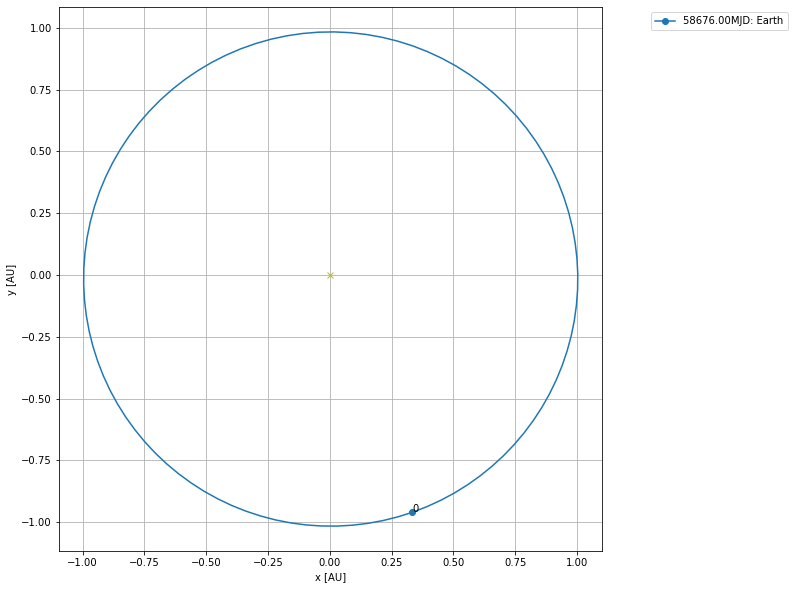

In [15]:
#PLOT!
fig = plt.figure(figsize=(10,10))
start_node.plot()
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

In [16]:
# check the children

children_1 = list(start_node.get_children(rtol=0.15*AU2km, epoch_horizon=120))

/Users/Devansh/Documents/GitHub/reGTOC04/jupyternotebooks/lambert_combine.py:145: RuntimeWarning: invalid value encountered in power
  residue = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
/Users/Devansh/Documents/GitHub/reGTOC04/jupyternotebooks/lambert_combine.py:145: RuntimeWarning: invalid value encountered in sqrt
  residue = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
/Users/Devansh/Documents/GitHub/reGTOC04/jupyternotebooks/lambert_combine.py:150: RuntimeWarning: invalid value encountered in power
  Fdot = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 1.5) * (((1/(2*z)) * (_Stumpff_C(z) - 3*_Stumpff_S(z)/(2*_Stumpff_C(z)))) + 3*np.power(_Stumpff_S(z),2)/(4*_Stumpff_C(z))) + (A/8)*(3*_Stumpff_S(z)*np.sqrt(_y_538(r1,r2,A,z))/_Stumpff_C(z) + A*np.sqrt(_Stumpff_C(z)/_y_538(r1,r2,A,z)))
/Users/Devansh/Documents/GitHub/reGTOC04/jupyternotebooks/lambert_co

MJD 58726.00,      1,    '1620',
MJD 58706.00,    127,    '141593',
MJD 58786.00,    164,    '162082',
MJD 58736.00,    356,    '2000QW7',
Failed to generate child at astindex:401, epoch:58676
MJD 58696.00,    415,    '2001RP3',
MJD 58766.00,    427,    '2001TB',
MJD 58726.00,    498,    '2002JR100',
MJD 58726.00,    660,    '2003YG136',
MJD 58746.00,    753,    '2004SA20',
Failed to generate child at astindex:860, epoch:58676
MJD 58736.00,   1054,    '2006QS23',
MJD 58746.00,   1057,    '2006QV89',
MJD 58676.00,   1065,    '2006RO36',


/Users/Devansh/Documents/GitHub/reGTOC04/jupyternotebooks/angles.py:99: RuntimeWarning: invalid value encountered in log
  / (np.sqrt(ecc + 1) - np.sqrt(ecc - 1) * np.tan(TA / 2))
/Users/Devansh/anaconda3/lib/python3.6/site-packages/scipy/optimize/zeros.py:295: RuntimeWarning: Derivative was zero.
  warnings.warn(msg, RuntimeWarning)


Failed to generate child at astindex:1114, epoch:58676
MJD 58786.00,   1125,    '2006XP4',
MJD 58716.00,   1151,    '2007DS7',
MJD 58736.00,   1209,    '2007RQ12',
MJD 58726.00,   1311,    '2008CY118',
MJD 58786.00,   1385,    '2008RH1',
MJD 58726.00,   1394,    '2008SJ82',
MJD 58736.00,   1398,    '2008SR1',
MJD 58786.00,   1420,    '2008UB7',


In [17]:
children_1

[MJD 58726.00,      1,    '1620',,
 MJD 58706.00,    127,    '141593',,
 MJD 58786.00,    164,    '162082',,
 MJD 58736.00,    356,    '2000QW7',,
 MJD 58696.00,    415,    '2001RP3',,
 MJD 58766.00,    427,    '2001TB',,
 MJD 58726.00,    498,    '2002JR100',,
 MJD 58726.00,    660,    '2003YG136',,
 MJD 58746.00,    753,    '2004SA20',,
 MJD 58736.00,   1054,    '2006QS23',,
 MJD 58746.00,   1057,    '2006QV89',,
 MJD 58676.00,   1065,    '2006RO36',,
 MJD 58786.00,   1125,    '2006XP4',,
 MJD 58716.00,   1151,    '2007DS7',,
 MJD 58736.00,   1209,    '2007RQ12',,
 MJD 58726.00,   1311,    '2008CY118',,
 MJD 58786.00,   1385,    '2008RH1',,
 MJD 58726.00,   1394,    '2008SJ82',,
 MJD 58736.00,   1398,    '2008SR1',,
 MJD 58786.00,   1420,    '2008UB7',]

In [18]:
children_1[10]

MJD 58746.00,   1057,    '2006QV89',

In [19]:
children_2=list(children_1[10].get_children(rtol=0.15*AU2km, epoch_horizon=120))

MJD 58776.00,    164,    '162082',
MJD 58796.00,    243,    '1994WR12',
Failed to generate child at astindex:356, epoch:58746
MJD 58766.00,    427,    '2001TB',
Failed to generate child at astindex:498, epoch:58746
MJD 58826.00,    674,    '2004BG41',
Failed to generate child at astindex:753, epoch:58746
Failed to generate child at astindex:1054, epoch:58746
MJD 58786.00,   1125,    '2006XP4',
Failed to generate child at astindex:1209, epoch:58746
MJD 58776.00,   1290,    '2008AG1',
Failed to generate child at astindex:1394, epoch:58746
MJD 58796.00,   1420,    '2008UB7',


In [20]:
children_2

[MJD 58776.00,    164,    '162082',,
 MJD 58796.00,    243,    '1994WR12',,
 MJD 58766.00,    427,    '2001TB',,
 MJD 58826.00,    674,    '2004BG41',,
 MJD 58786.00,   1125,    '2006XP4',,
 MJD 58776.00,   1290,    '2008AG1',,
 MJD 58796.00,   1420,    '2008UB7',]

In [21]:
for i, child in enumerate(children_2):
    print(f'{i:3d}: {child} \t dv: {child.cost:3.4f}')

  0: MJD 58776.00,    164,    '162082', 	 dv: 5.3479
  1: MJD 58796.00,    243,    '1994WR12', 	 dv: 1.0628
  2: MJD 58766.00,    427,    '2001TB', 	 dv: 3.5743
  3: MJD 58826.00,    674,    '2004BG41', 	 dv: 3.6535
  4: MJD 58786.00,   1125,    '2006XP4', 	 dv: 3.8673
  5: MJD 58776.00,   1290,    '2008AG1', 	 dv: 7.8984
  6: MJD 58796.00,   1420,    '2008UB7', 	 dv: 1.7649


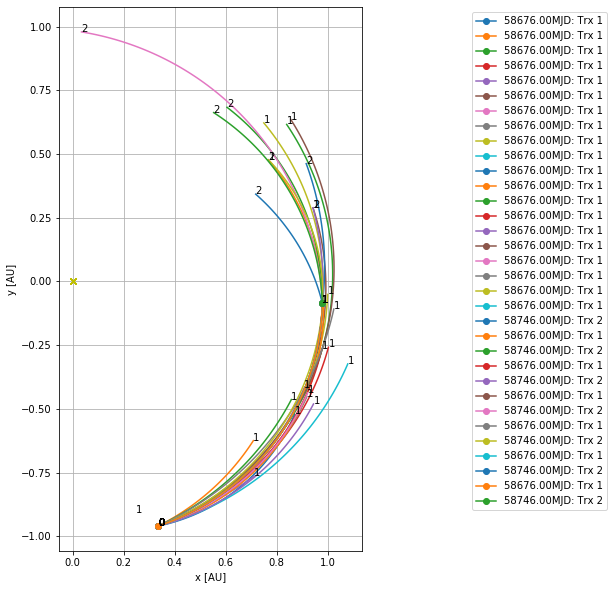

In [22]:
fig = plt.figure(figsize=(10,10))
for child in children_1:
    try:
        child.plot(only_traj=True) 
    except:
        pass
for child in children_2:
    try:
        child.plot(only_traj=True) 
    except:
        pass
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

In [23]:
children_3=list(children_2[4].get_children(rtol=0.15*AU2km, epoch_horizon=240))

MJD 58976.00,     22,    '4769',
MJD 58936.00,     92,    '101869',
MJD 59006.00,    118,    '138971',
MJD 58866.00,    139,    '152742',
Failed to generate child at astindex:243, epoch:58796
MJD 58996.00,    424,    '2001SQ3',
MJD 58916.00,    428,    '2001TD',
MJD 59006.00,    430,    '2001TY1',
MJD 58926.00,    475,    '2002CW11',
MJD 58836.00,    487,    '2002FW1',
MJD 58916.00,    534,    '2002VX91',
MJD 58946.00,    599,    '2003LN6',
MJD 58886.00,    627,    '2003SW130',
MJD 58866.00,    635,    '2003UC20',
MJD 58946.00,    691,    '2004FD',
MJD 58906.00,    708,    '2004JG6',
MJD 58976.00,    732,    '2004PR92',
MJD 58976.00,    797,    '2005BG28',
MJD 58956.00,    800,    '2005CD69',
MJD 58956.00,    887,    '2005SP1',
MJD 59016.00,    898,    '2005TM',
MJD 58936.00,    945,    '2005YP180',
MJD 59016.00,   1053,    '2006QQ56',
MJD 58986.00,   1076,    '2006TB',
MJD 58856.00,   1201,    '2007PH25',
MJD 59006.00,   1405,    '2008TB',
Failed to generate child at astindex:1420, ep

# Define the first node
based on sequences found in russian paper

In [24]:
first_node = start_node.create_next_node(target_ind=1057, target_epoch=58731.65)

In [25]:
# get cost and priority
first_node.cost, first_node.get_priority()

(0.0, -0.0)

In [26]:
print(first_node.history())

Epoch,         Index,    Name,

MJD 58676.00,     -1,    Earth,
MJD 58731.65,   1057,    '2006QV89',


In [ ]:
first_node.len_of_chain()

In [ ]:
# PLOT
fig = plt.figure(figsize=(10,10))
first_node.plot() 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

In [ ]:
# PLOT
fig = plt.figure(figsize=(10,10))
first_node.plot(only_traj=True) 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# second node

In [ ]:
second_node = first_node.create_next_node(target_ind=1125, target_epoch=58801.45)

In [ ]:
second_node.maneuvers

In [ ]:
second_node.cost, second_node.get_priority()

In [ ]:
fig = plt.figure(figsize=(10,10))
second_node.plot() 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# thrid node

In [ ]:
third_node = second_node.create_next_node(target_ind=1328, target_epoch=58866.95)

In [ ]:
print(third_node.history())

In [ ]:
third_node.maneuvers

In [ ]:
third_node.cost

In [ ]:
fig = plt.figure(figsize=(10,10))
third_node.plot() 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

In [ ]:
fig = plt.figure(figsize=(10,10))
third_node.plot(only_traj=True) 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# Try to define a sequence
based on russian paper

In [28]:
t_list = [58731.65, 58801.45, 58866.95, 58973.95, 59084.55, 59119.45, 59221.75,59326.95, 59366.25,59419.55]
ind_list = [1057, 1125, 1328, 1181, 937,1077, 1289, 1000, 601, 1376]

In [29]:
nodes = [start_node]

In [30]:
for i, ind in enumerate(ind_list):
    new_node = nodes[-1].create_next_node(target_ind = ind, target_epoch=t_list[i])
    nodes.append(new_node)
    

In [31]:
nodes

[MJD 58676.00,     -1,    Earth,,
 MJD 58731.65,   1057,    '2006QV89',,
 MJD 58801.45,   1125,    '2006XP4',,
 MJD 58866.95,   1328,    '2008EP6',,
 MJD 58973.95,   1181,    '2007KV2',,
 MJD 59084.55,    937,    '2005XN27',,
 MJD 59119.45,   1077,    '2006TB7',,
 MJD 59221.75,   1289,    '2008AF4',,
 MJD 59326.95,   1000,    '2006HF6',,
 MJD 59366.25,    601,    '2003LW2',,
 MJD 59419.55,   1376,    '2008PK3',]

In [32]:
final_node = nodes[-1]

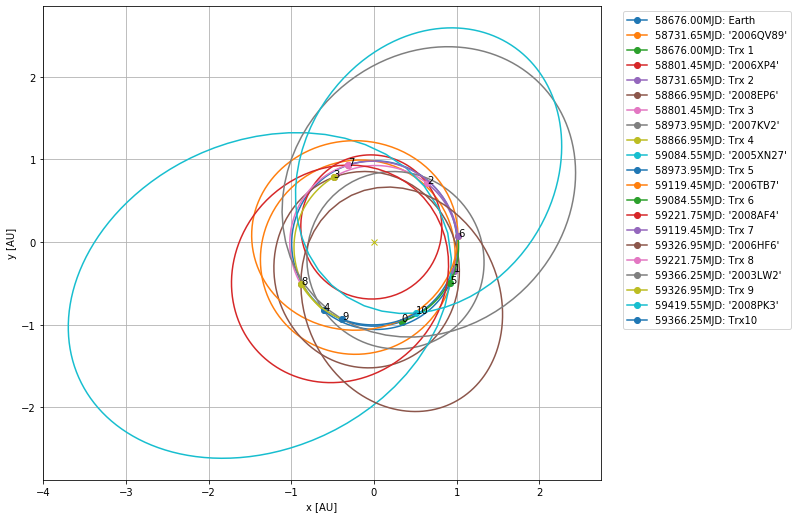

In [33]:
fig = plt.figure(figsize=(10,10))
final_node.plot()
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))


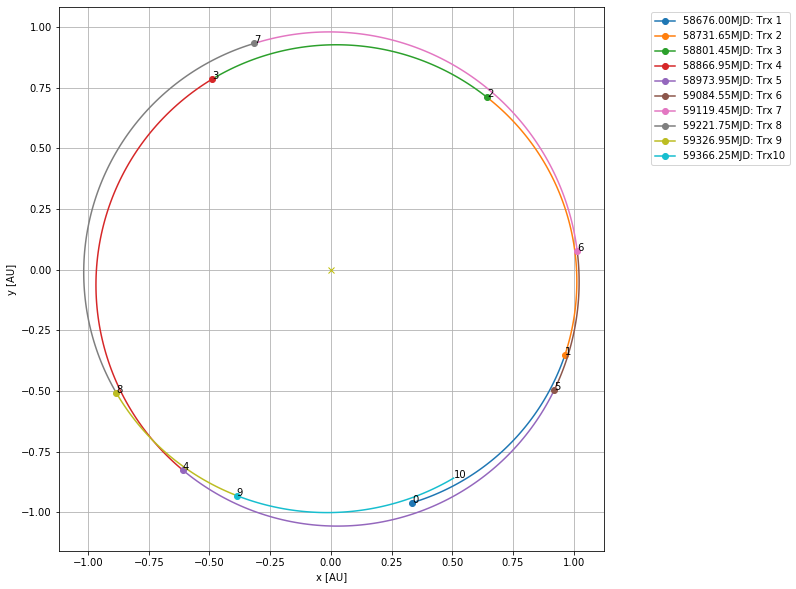

In [34]:
fig = plt.figure(figsize=(10,10))
final_node.plot(only_traj=True)
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

In [35]:
final_node.maneuvers

[(58676, array([-0.20723289, -1.4236052 ,  0.07245879])),
 (58731.65, array([-0.11815005,  0.07754495,  0.20063831])),
 (58801.45, array([-0.32988735,  0.52634144,  0.14795608])),
 (58866.95, array([0.15972231, 0.02929418, 0.02763234])),
 (58973.95, array([ 0.04873194, -0.08043569,  0.26002869])),
 (59084.55, array([ 0.20222521,  0.30944667, -0.10444501])),
 (59119.45, array([-0.02882234,  0.15765074, -0.05001421])),
 (59221.75, array([0.5126921 , 0.58991377, 0.14833961])),
 (59326.95, array([ 0.12108697, -0.09079498, -0.04067516])),
 (59366.25, array([ 0.4458898 , -0.16419913,  0.43552919]))]

In [36]:
final_node.cost

3.4740318549150957

In [37]:
final_node.get_priority(dv=False, mf=True, count=False)

-0.8886212095815822

In [44]:
np.exp(-final_node.cost/(ISP*g0/1000))

0.8886212095815822

In [45]:
final_node.maneuvers[0][1]

array([-0.20723289, -1.4236052 ,  0.07245879])